# Imports

In [471]:
import re
import nltk
import requests
import pandas as pd
import seaborn as sns
from nltk import ngrams
from nltk import FreqDist
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/congrendai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Activity 3

## 3.1 Sub-activity: Loading and pre-processing of text data

In [472]:
# Global variables
WIKIDATA_API_ENDPOINT = "https://www.wikidata.org/w/api.php"

WIKIDATA_COMMON_PARAMS = {
    "ids":"",
    "props": "",
    "format":"json",
    "languages": "en",
    "formatversion": "2",
    "sitefilter": "enwiki",
    "action": "wbgetentities"
}

### Task 1

In [473]:
def get_turing_award_recipients():

    wikidata_entity_params = {
        "srlimit":100,
        "format":"json",
        "list":"search",
        "action":"query",
        "formatversion": "2",
        "srprop":"sectiontitle",
        "srsearch": "haswbstatement:P166=Q185667",
    }
    
    wikidata_ID_response = requests.get(WIKIDATA_API_ENDPOINT, params = wikidata_entity_params)
    wikidata_ID_data = wikidata_ID_response.json()    
    wikidata_IDs = [entity_ID["title"] for entity_ID in wikidata_ID_data["query"]["search"]]

    return wikidata_IDs

In [474]:
wikidata_IDs = get_turing_award_recipients()

### Task 2

In [475]:
def get_wikipedia_content(wikidata_ID):
    wikipedia_API_endpoint = "https://en.wikipedia.org/w/api.php"
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "sitelinks"
    
    wikidata_response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    wikidata_response_data = wikidata_response.json()

    # To extract content from the wikipidia page, we have to use titles gained the wikidata IDs, since the titles of wikipedia pages are unique.
    wikidata_title = wikidata_response_data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"]    

    wikipedia_params = {
        "titles": "",
        "format": "json",
        "action": "query",
        "prop": "extracts",
        "formatversion": "2",
        "titles": wikidata_title,
        "exsectionformat": "wiki"
    }
    
    wikipedia_content_response = requests.get(wikipedia_API_endpoint, params = wikipedia_params)
    wikipedia_content_data = wikipedia_content_response.json()
    wikipedia_content = wikipedia_content_data["query"]["pages"][0]["extract"]
    return wikipedia_content


### Task 3

In [476]:
def get_award_winners_info(wikidata_ID):
    
    WIKIDATA_COMMON_PARAMS["ids"] = wikidata_ID
    WIKIDATA_COMMON_PARAMS["props"] = "claims|sitelinks"

    response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
    data = response.json()

    # Extract name
    try:
        # Some names have brackets, so we split that part and take the name
        wikidata_name = data["entities"][wikidata_ID]["sitelinks"]["enwiki"]["title"].split(" (")[0]
    except KeyError:
        wikidata_name = None

    # Extract intro from wikipedia page
    try:
        wikipedia_content = get_wikipedia_content(wikidata_ID)
        content_remove_newline_to_space = wikipedia_content.replace("\n", " ")
        content_with_p_tag = re.sub(r"<\/?(?!p)\w*\b[^>]*>", "", content_remove_newline_to_space.split("<h2>")[0])
        paragraphs = re.findall(r'<p>(.+?)</p>', content_with_p_tag)
        wikipedia_intro = "\n".join(paragraphs)
    except KeyError:
        wikipedia_intro = None

    # Extract gender ID to get gender from "sex or gender (P21)"
    try:
        wikidata_gender_id = data["entities"][wikidata_ID]["claims"]["P21"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_gender_id = None
        
    # Get birth date from "date of birth (P569)"
    try:
        wikidata_birth_date = data["entities"][wikidata_ID]["claims"]["P569"][0]["mainsnak"]["datavalue"]["value"]["time"].split("T")[0].split("+")[1]
    except KeyError:
        wikidata_birth_date = None

    # Extract birth place ID to get birth place from "place of birth (P19)"
    try:
        wikidata_birth_place_id = data["entities"][wikidata_ID]["claims"]["P19"][0]["mainsnak"]["datavalue"]["value"]["id"]
    except KeyError:
        wikidata_birth_place_id = None

    # Extract employer ID to get employer from "employer (P108)"
    # employer ID is inside of "mainsnak" key
    try:
        wikidata_employer_mainsnaks = data["entities"][wikidata_ID]["claims"]["P108"]
        wikidata_employer_IDs = "|".join([wikidata_employer_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_employer_ID in wikidata_employer_mainsnaks])
    except KeyError:
        wikidata_employer_IDs = None
        
    # Extract educated at ID to get educated at from "educated at (P69)"
    # educated at ID is inside of "mainsnak" key
    try:
        wikidata_educated_at_mainsnaks = data["entities"][wikidata_ID]["claims"]["P69"]
        wikidata_educated_at_IDs = "|".join([wikidata_educated_at_ID["mainsnak"]["datavalue"]["value"]["id"] for wikidata_educated_at_ID in wikidata_educated_at_mainsnaks])
    except KeyError:
        wikidata_educated_at_IDs = None

    # Join the IDs per winner that we want to get info from into a list
    entity_info_request_IDs = [wikidata_gender_id, wikidata_birth_place_id, wikidata_employer_IDs, wikidata_educated_at_IDs]
    
    # A list that contains all the info of the winner
    
    entity_info = [wikidata_name, wikipedia_intro, wikidata_birth_date]

    WIKIDATA_COMMON_PARAMS["props"] = "labels"
    for i in range(len(entity_info_request_IDs)):
        entity_values = []
        
        WIKIDATA_COMMON_PARAMS["ids"] = entity_info_request_IDs[i]
        
        response = requests.get(WIKIDATA_API_ENDPOINT, params = WIKIDATA_COMMON_PARAMS)
        data = response.json()

        if i == 0 or i == 1:
            try:
                entity_value = data["entities"][entity_info_request_IDs[i]]["labels"]["en"]["value"]
                entity_info.append(entity_value)
            except KeyError:
                entity_info.append(None)

        else:
            try:
                entity_IDs = entity_info_request_IDs[i].split("|")
            except AttributeError:
                entity_IDs = []

            for entity_ID in entity_IDs:
                try:
                    entity_value = data["entities"][entity_ID]["labels"]["en"]["value"]
                    entity_values.append(entity_value)
                except KeyError:
                    entity_values.append(None)
            
            entity_info.append(entity_values)
    
    return entity_info[0], entity_info[1], entity_info[2], entity_info[3], entity_info[4], entity_info[5], entity_info[6]

In [477]:
# To get the data for all the winners
award_winners = {
    "name": [],
    "intro": [],
    "birth_date": [],
    "gender": [],
    "birth_place": [],
    "employer": [],
    "educated_at": []
}

for wikidata_ID in wikidata_IDs:
    wikidata_name, wikipedia_intro, wikidata_birth_date, wikidata_gender, wikidata_birth_place, wikidata_employer, wikidata_educated_at = get_award_winners_info(wikidata_ID)
    award_winners["name"].append(wikidata_name)
    award_winners["intro"].append(wikipedia_intro)
    award_winners["birth_date"].append(wikidata_birth_date)
    award_winners["gender"].append(wikidata_gender)
    award_winners["birth_place"].append(wikidata_birth_place)
    # Remove duplicates from employer and educated at
    award_winners["employer"].append(list(set(wikidata_employer)))
    award_winners["educated_at"].append(list(set(wikidata_educated_at)))

### Task 4

In [478]:
print("The names of all award winners in alphabetical order are : \n\n{}.".format(", ".join(sorted(award_winners["name"]))))

The names of all award winners in alphabetical order are : 

Adi Shamir, Alan Kay, Alan Perlis, Alfred Aho, Allen Newell, Amir Pnueli, Andrew Yao, Barbara Liskov, Bob Kahn, Butler Lampson, Charles Bachman, Charles P. Thacker, Dana Scott, David Patterson, Dennis Ritchie, Donald Knuth, Douglas Engelbart, E. Allen Emerson, Edgar F. Codd, Edmund M. Clarke, Edsger W. Dijkstra, Edward Feigenbaum, Edwin Catmull, Fernando J. Corbató, Frances Allen, Fred Brooks, Geoffrey Hinton, Herbert A. Simon, Ivan Sutherland, Jack Dongarra, James H. Wilkinson, Jeffrey Ullman, Jim Gray, John Backus, John Cocke, John Hopcroft, John L. Hennessy, John McCarthy, Joseph Sifakis, Judea Pearl, Juris Hartmanis, Ken Thompson, Kenneth E. Iverson, Kristen Nygaard, Leonard Adleman, Leslie Lamport, Leslie Valiant, Manuel Blum, Martin Hellman, Marvin Minsky, Maurice Wilkes, Michael O. Rabin, Michael Stonebraker, Niklaus Wirth, Ole-Johan Dahl, Pat Hanrahan, Peter Naur, Raj Reddy, Richard E. Stearns, Richard Hamming, Richar

### Task 5

#### (a)

In [479]:
award_winners_intro = pd.DataFrame(columns = ["winner_name", "count_words", "count_sentences", "count_paragraphs", "common_words"])

#### (b)

In [480]:
award_winners_intro["winner_name"] = award_winners["name"]
award_winners_intro["count_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: re.sub(r"[^\w\s]", "", x[0]).split(), axis = 1).apply(lambda x: len(x))
award_winners_intro["count_sentences"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: sent_tokenize(x[0]), axis = 1).apply(lambda x: len(x))
award_winners_intro["count_paragraphs"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: x[0].split("\n"), axis = 1).apply(lambda x: len(x))
award_winners_intro["common_words"] = pd.DataFrame(award_winners["intro"]).apply(lambda x: FreqDist(x[0].split()).most_common(10), axis = 1).apply(lambda x: [i[0] for i in x]).apply(lambda x: ", ".join(x))

#### (c)

In [481]:
en_stopwords = stopwords.words("english")
award_winners_intro_remove_stopwords_and_punctuation = pd.DataFrame(award_winners["intro"]).apply(lambda x: " ".join([word for word in word_tokenize(re.sub(r"[^\w\s]", "", x[0])) if word.lower() not in en_stopwords]), axis = 1)
award_winners_intro["common_words_after_preprocessing"] = award_winners_intro_remove_stopwords_and_punctuation.apply(lambda x: FreqDist(re.sub(r"[^\w\s]", "", x).split()).most_common(10)).apply(lambda x: [i[0] for i in x]).apply(lambda x: ", ".join(x))

#### (d)

In [482]:
award_winners_intro.head(10)

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide","Web, World, Wide, BernersLee, Computer, Scienc..."
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ...","Bengio, work, deep, learning, Learning, Hinton..."
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is","Hinton, computer, work, neural, networks, Goog..."
3,Donald Knuth,183,8,3,"the, of, and, Knuth, computer, is, to, He, ana...","Knuth, computer, science, analysis, algorithms..."
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the...","Karp, computer, theory, algorithms, Richard, M..."
5,Robert Tarjan,62,3,1,"and, is, the, of, Tarjan, at, Robert, Endre, (...","Tarjan, University, Robert, Endre, born, April..."
6,Vint Cerf,64,2,1,"the, of, and, is, National, Medal, Vinton, Gra...","Internet, National, Medal, Vinton, Gray, Cerf,..."
7,Judea Pearl,156,5,2,"the, and, of, for, is, on, Pearl, a, in, Judea","Pearl, Judea, computer, probabilistic, artific..."
8,Herbert A. Simon,180,7,2,"the, of, and, was, in, science,, to, political...","science, political, computer, Simon, 2001, fie..."
9,Marvin Minsky,53,2,2,"and, of, Minsky, the, AI, Marvin, Lee, (August...","AI, Minsky, Marvin, Lee, August, 9, 1927, Janu..."


## 3.2 Sub-activity: Applying NLP operations on the corpus

### 3.2.1 Stemming

### Task 3

#### (a)

In [483]:
intro_words = []
for intro in award_winners["intro"]:
    # Remove punctuations
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", intro))
    # Remove stopwords
    for word in tokens:
        if word.lower() not in en_stopwords:
            intro_words.append(word)

#### (b)

In [484]:
unique_words = len(FreqDist([word.lower() for word in intro_words]).keys())
print("The number of unique words in intro_words is: {}.".format(unique_words))

The number of unique words in intro_words is: 1645.


#### (c)

In [485]:
porter_stemmer = PorterStemmer()
print("The number of unique words after porter stemming in intro_words is: {}.".format(len(FreqDist([porter_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words after porter stemming in intro_words is: 1427.


### Task 4

In [507]:
snowball_stemmer = SnowballStemmer("english")
print("The number of unique words in intro_words is: {}.".format(unique_words))
print("The number of unique words after snowball stemming in intro_words is: {}.".format(len(FreqDist([snowball_stemmer.stem(word) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1645.
The number of unique words after snowball stemming in intro_words is: 1425.


### 3.2.2 Lemmatization

### Task 5

In [506]:
wordnet_lemmatizer = WordNetLemmatizer()
print("The number of unique words in intro_words is: {}.".format(unique_words))
print("The number of unique words after lemmatization in intro_words is: {}.".format(len(FreqDist([wordnet_lemmatizer.lemmatize(word.lower()) for word in intro_words]).keys())))

The number of unique words in intro_words is: 1645.
The number of unique words after lemmatization in intro_words is: 1572.


### 3.2.3 Finding synonyms and antonyms

### Task 6

#### (a)

In [488]:
# Add synonyms and antonyms columns to award_winners_intro
award_winners_intro = award_winners_intro.reindex(award_winners_intro.columns.to_list() + ["synonyms", "antonyms"], axis = 1)

#### (b)

In [489]:
def get_synonyms(words):
    synonyms = []
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())
    return synonyms

In [490]:
award_winners_intro["synonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_synonyms(word_tokenize(x)))

#### (c)

In [491]:
def get_antonyms(words):
    antonyms = []
    for word in words:
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                if lemma.antonyms():
                    antonyms.append(lemma.antonyms()[0].name())
    return antonyms

In [492]:
award_winners_intro["antonyms"] = award_winners_intro["common_words_after_preprocessing"].apply(lambda x: get_antonyms(word_tokenize(x)))

#### (d)

In [493]:
award_winners_intro.iloc[0:10,:]

,winner_name,count_words,count_sentences,count_paragraphs,common_words,common_words_after_preprocessing,synonyms,antonyms
0,Tim Berners-Lee,359,17,4,"the, of, and, He, a, is, Web, as, World, Wide","Web, World, Wide, BernersLee, Computer, Scienc...","[web, web, entanglement, vane, web, network, w...","[narrow, narrow, middle, last, second, ignore,..."
1,Yoshua Bengio,91,4,2,"and, the, of, for, Bengio, is, a, work, deep, ...","Bengio, work, deep, learning, Learning, Hinton...","[work, work, piece_of_work, employment, work, ...","[idle, malfunction, shallow, shallow, unborn]"
2,Geoffrey Hinton,181,8,3,"the, and, of, for, in, Hinton, a, his, to, is","Hinton, computer, work, neural, networks, Goog...","[computer, computing_machine, computing_device...","[idle, malfunction, shallow, shallow]"
3,Donald Knuth,183,8,3,"the, of, and, Knuth, computer, is, to, He, ana...","Knuth, computer, science, analysis, algorithms...","[computer, computing_machine, computing_device...","[synthesis, undesigned]"
4,Richard M. Karp,92,3,2,"in, and, the, of, for, Karp, is, computer, the...","Karp, computer, theory, algorithms, Richard, M...","[computer, computing_machine, computing_device...",[unborn]
5,Robert Tarjan,62,3,1,"and, is, the, of, Tarjan, at, Robert, Endre, (...","Tarjan, University, Robert, Endre, born, April...","[university, university, university, Robert, H...",[unborn]
6,Vint Cerf,64,2,1,"the, of, and, is, National, Medal, Vinton, Gra...","Internet, National, Medal, Vinton, Gray, Cerf,...","[internet, net, cyberspace, national, subject,...","[international, local, unborn]"
7,Judea Pearl,156,5,2,"the, and, of, for, is, on, Pearl, a, in, Judea","Pearl, Judea, computer, probabilistic, artific...","[pearl, bone, ivory, pearl, off-white, drop, b...","[natural, stupidity, devolution, nondevelopment]"
8,Herbert A. Simon,180,7,2,"the, of, and, was, in, science,, to, political...","science, political, computer, Simon, 2001, fie...","[science, scientific_discipline, skill, scienc...",[nonpolitical]
9,Marvin Minsky,53,2,2,"and, of, Minsky, the, AI, Marvin, Lee, (August...","AI, Minsky, Marvin, Lee, August, 9, 1927, Janu...","[Army_Intelligence, AI, artificial_intelligenc...",[windward]


### 3.2.4 Bigrams and trigrams

### Task 7

In [494]:
intros_tokenized = []
for intro in award_winners["intro"]:
    tokens = word_tokenize(intro)
    intros_tokenized.append(tokens)

### Task 8

In [495]:
def get_bigrams_frequency(intros):
    intro_no_punctuations_stopwords = []
    for intro in intros:
        for word in intro:
            # Remove punctuations and stopwords
            if word.lower() not in en_stopwords and word.isalnum():
                intro_no_punctuations_stopwords.append(word)
    bigrams = ngrams(intro_no_punctuations_stopwords, 2)
    return dict(FreqDist(bigrams))

### Task 9

In [496]:
winners_bigrams = get_bigrams_frequency(intros_tokenized)

### Task 10

In [497]:
most_15_common_bigrams = dict(sorted(winners_bigrams.items(), key = lambda x: x[1], reverse = True)[:15])
print("The most 15 most frequently occurring bigrams are: {}".format(", ".join(str(key) for key in list(most_15_common_bigrams.keys()))))

The most 15 most frequently occurring bigrams are: ('computer', 'scientist'), ('Turing', 'Award'), ('American', 'computer'), ('computer', 'science'), ('Computer', 'Science'), ('programming', 'language'), ('best', 'known'), ('National', 'Academy'), ('artificial', 'intelligence'), ('programming', 'languages'), ('received', 'Turing'), ('ACM', 'Turing'), ('Academy', 'Engineering'), ('Carnegie', 'Mellon'), ('Stanford', 'University')


## 3.3 Sub-section: Visualisation

### 3.3.1 Barplots

### Task 11

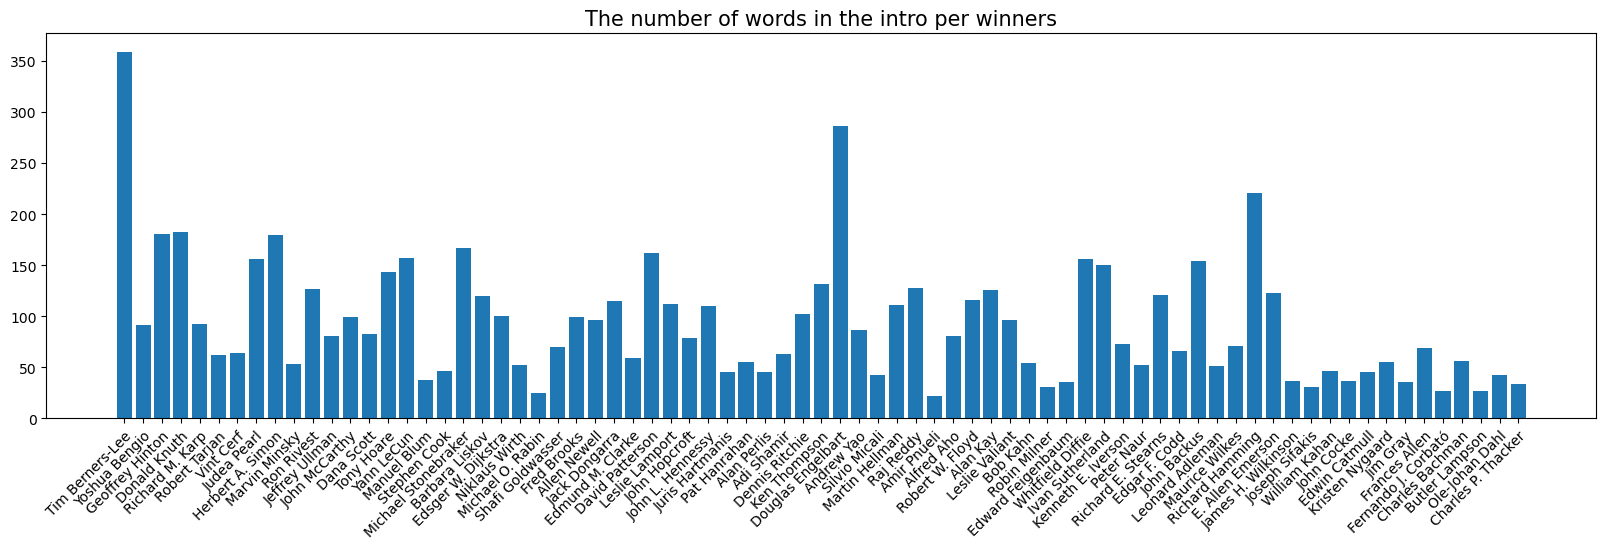

In [498]:
plt.figure(figsize=(20, 5))
plt.title("The number of words in the intro per winners", fontsize = 15)
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])
plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

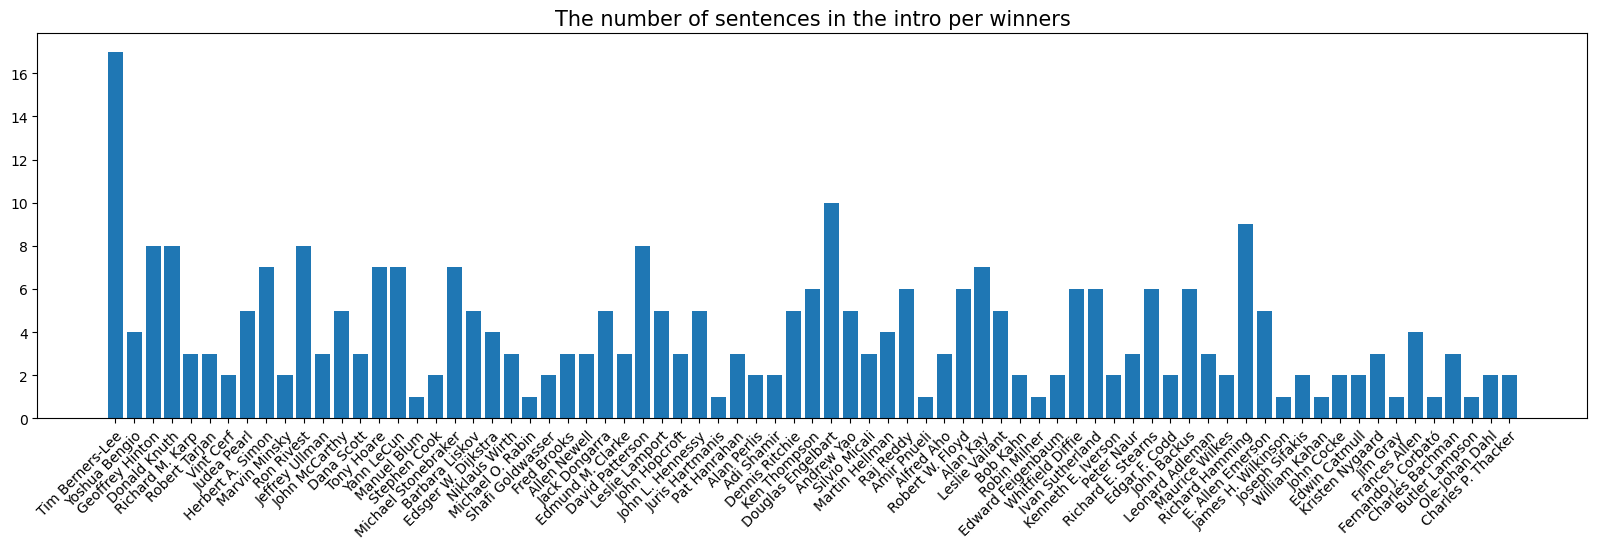

In [499]:
plt.figure(figsize=(20, 5))
plt.title("The number of sentences in the intro per winners", fontsize = 15)
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])
plt.xticks(rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

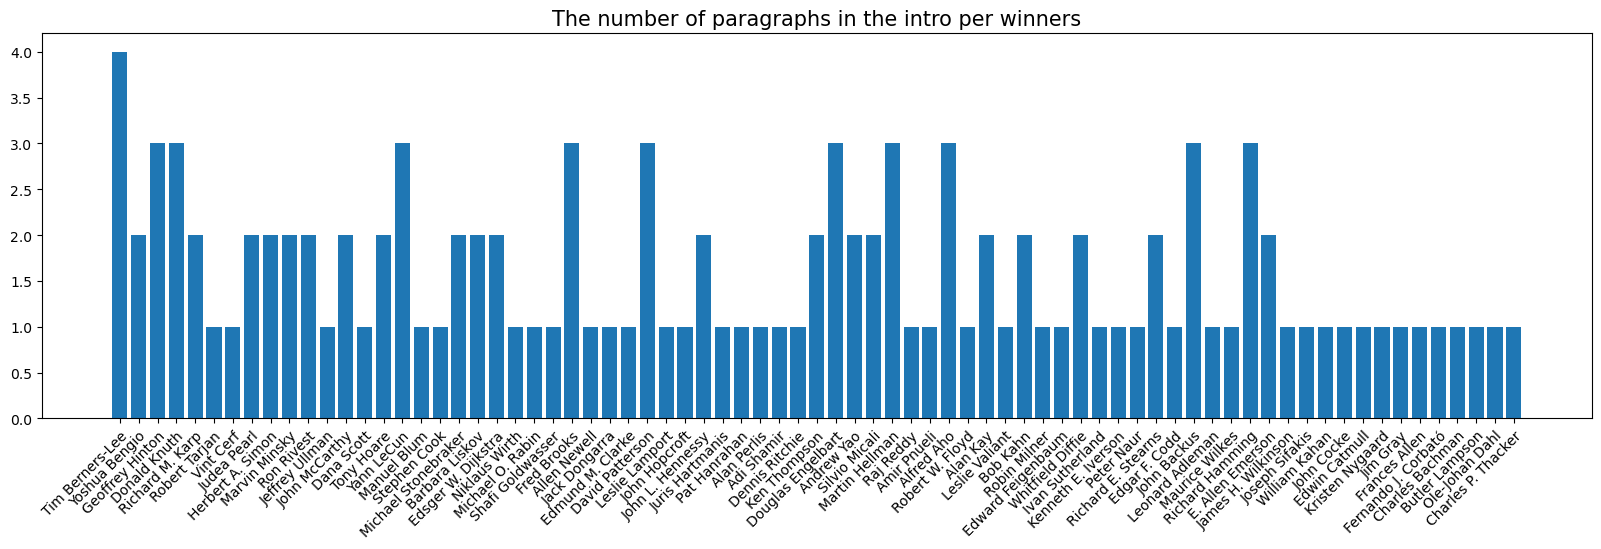

In [500]:
plt.figure(figsize=(20, 5))
plt.title("The number of paragraphs in the intro per winners", fontsize = 15)
plt.bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])
plt.xticks(rotation = 45, ha = "right", rotation_mode = 'anchor')
plt.show()

### Task 12

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_63015/1264747863.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_63015/1264747863.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_63015/1264747863.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')


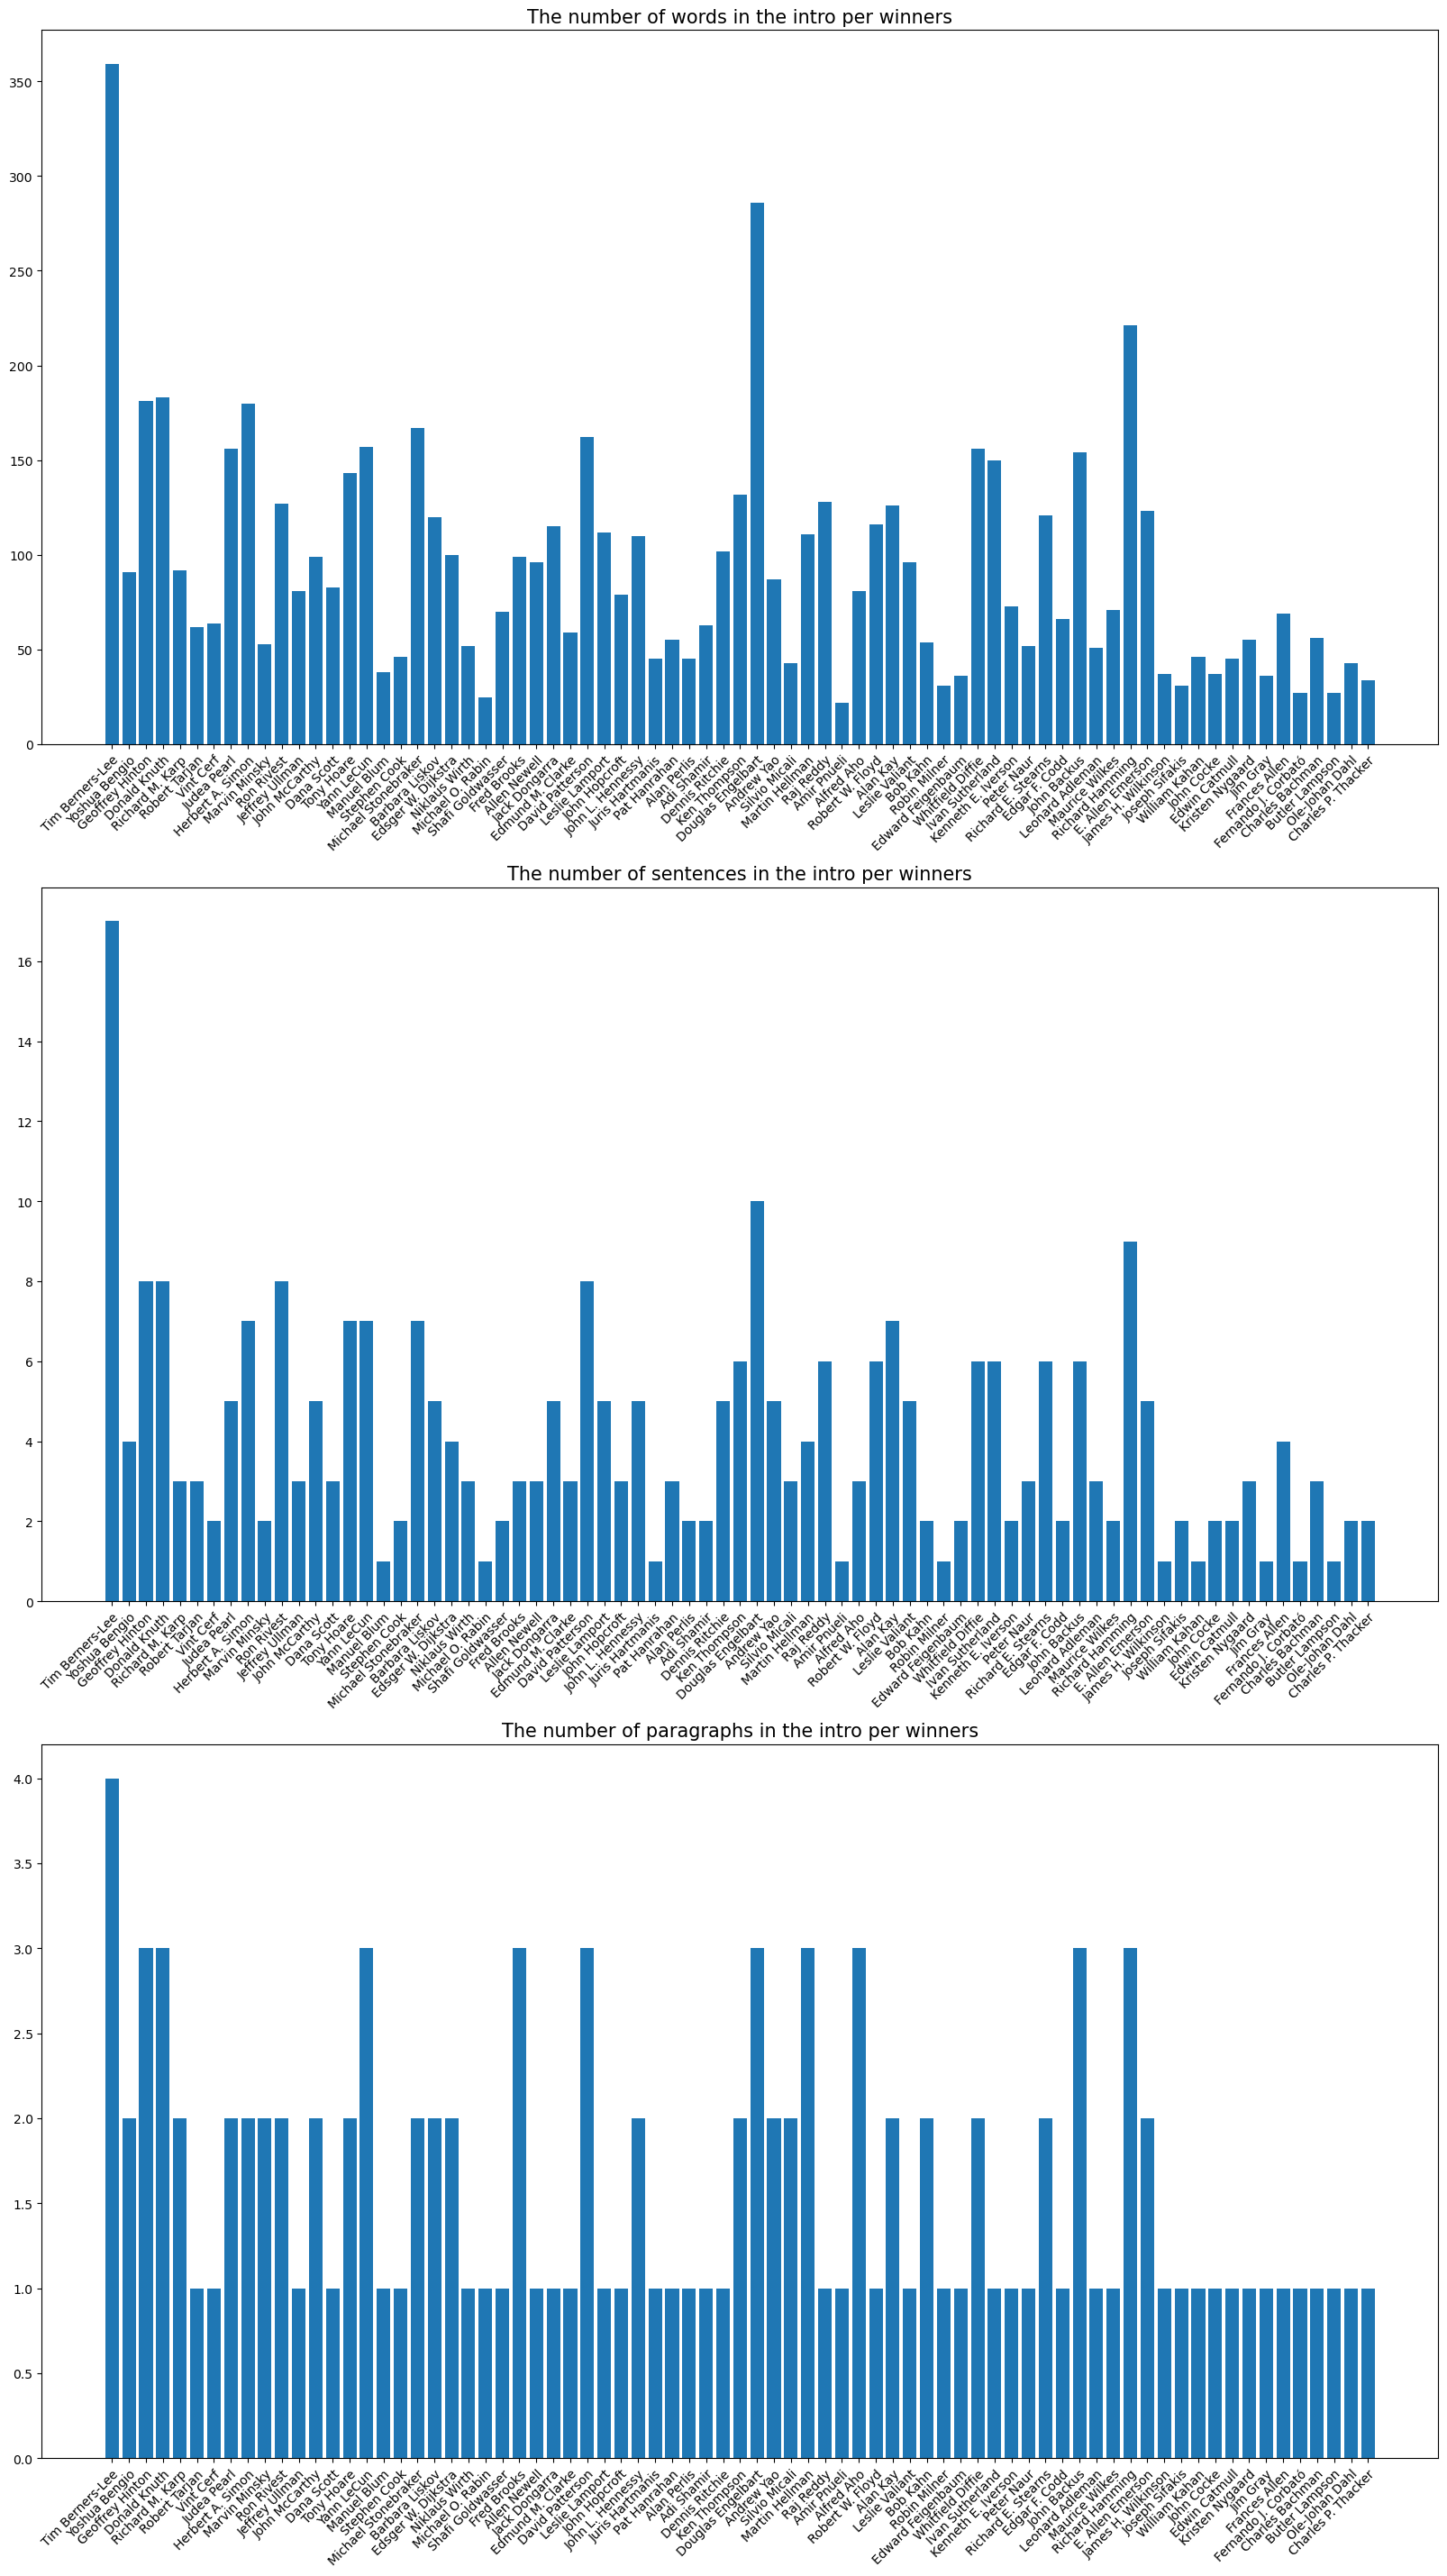

In [501]:
fig, axs = plt.subplots(3,1, figsize = (20, 35))
axs[0].set_title("The number of words in the intro per winners", fontsize = 15)
axs[0].bar(award_winners_intro["winner_name"], award_winners_intro["count_words"])
axs[0].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[1].set_title("The number of sentences in the intro per winners", fontsize = 15)
axs[1].bar(award_winners_intro["winner_name"], award_winners_intro["count_sentences"])
axs[1].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
axs[2].set_title("The number of paragraphs in the intro per winners", fontsize = 15)
axs[2].bar(award_winners_intro["winner_name"], award_winners_intro["count_paragraphs"])
axs[2].set_xticklabels(award_winners_intro["winner_name"], rotation = 45, ha = "right", rotation_mode='anchor')
plt.show()

### Task 13

/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_63015/1375611208.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(sorted_word_count["winner_name"], rotation = 90)
/var/folders/dn/rwz32gqj5951m0mt9y7smnn80000gn/T/ipykernel_63015/1375611208.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)


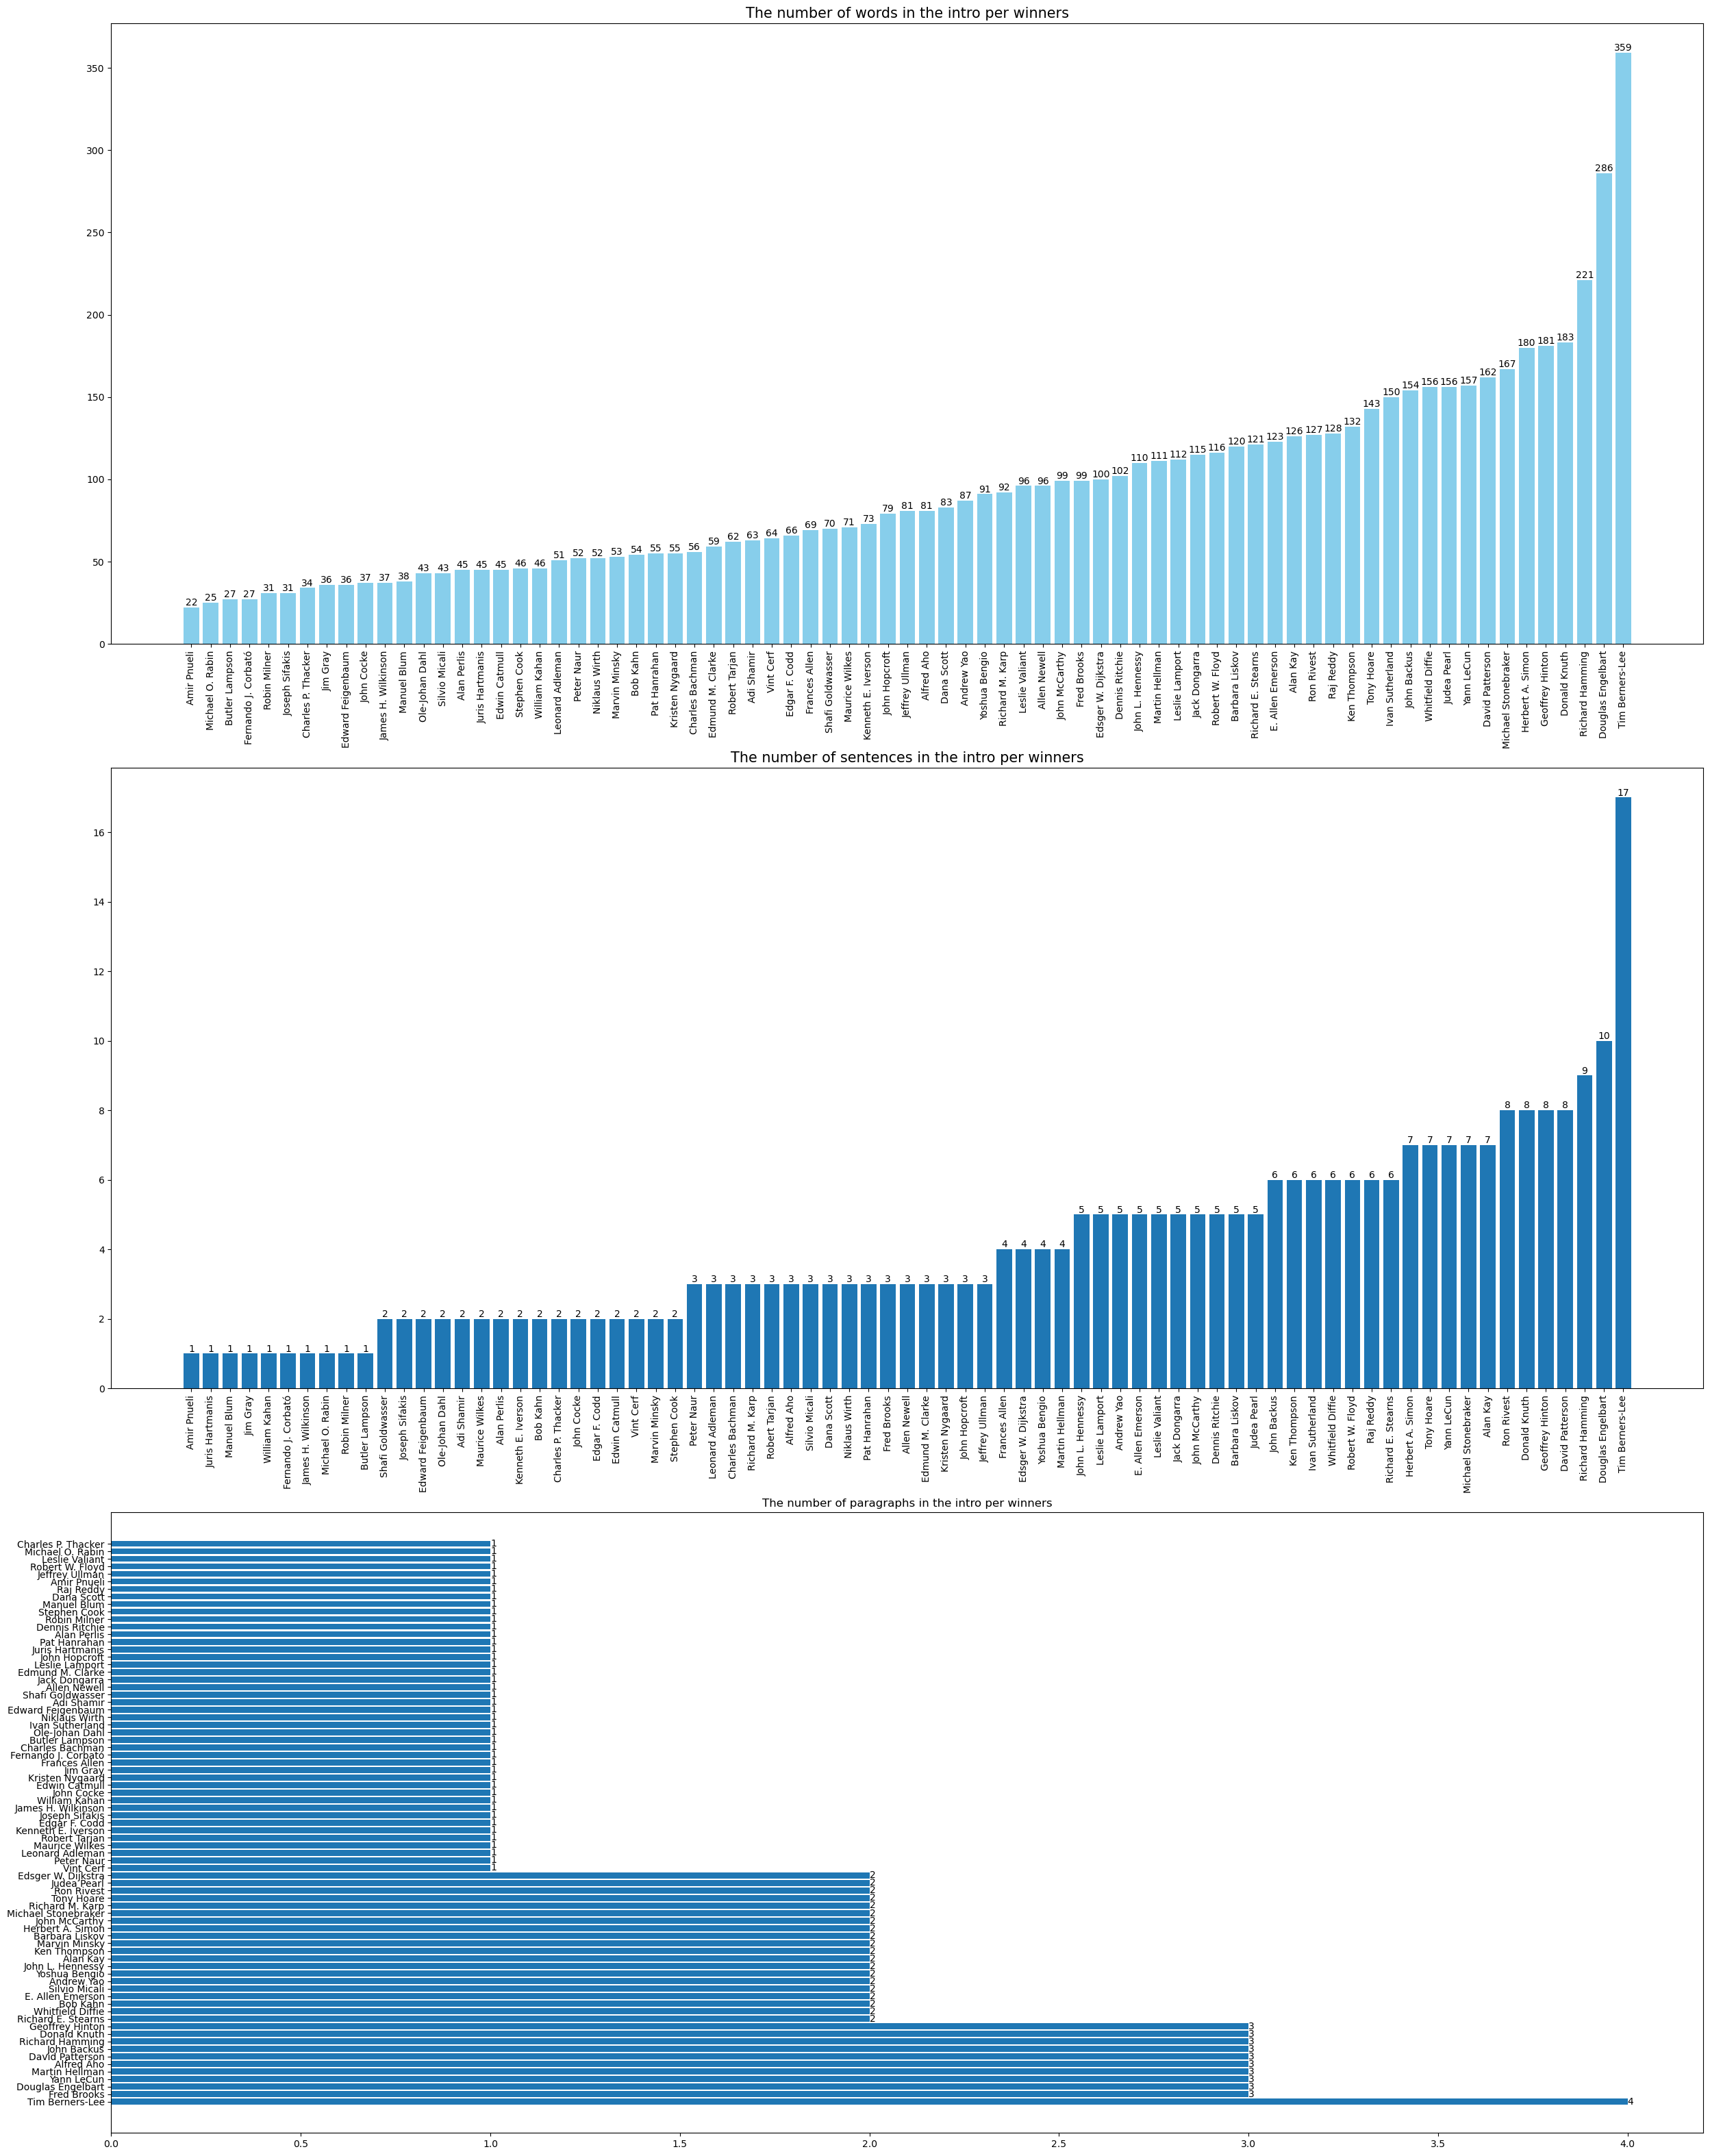

In [502]:
sorted_word_count = award_winners_intro.sort_values(by = "count_words", ascending = True)
sorted_sentence_count = award_winners_intro.sort_values(by = "count_sentences", ascending = True)
sorted_paragraph_count = award_winners_intro.sort_values(by = "count_paragraphs", ascending = False)

fig, axs = plt.subplots(3,1, figsize = (30, 40))
axs[0].set_title("The number of words in the intro per winners", fontsize = 15)
axs[0].bar(sorted_word_count["winner_name"], sorted_word_count["count_words"], color = "skyblue")
axs[0].bar_label(axs[0].containers[0])
axs[0].set_xticklabels(sorted_word_count["winner_name"], rotation = 90)
axs[1].set_title("The number of sentences in the intro per winners", fontsize = 15)
axs[1].bar(sorted_sentence_count["winner_name"], sorted_sentence_count["count_sentences"])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_xticklabels(sorted_sentence_count["winner_name"], rotation = 90)
axs[2].set_title("The number of paragraphs in the intro per winners")
axs[2].barh(sorted_paragraph_count["winner_name"], sorted_paragraph_count["count_paragraphs"])
axs[2].bar_label(axs[2].containers[0])
plt.show()

### 3.3.2 Heatmap

### Task 14

In [503]:
intros_remove_stopword_punctuation = []
for intro in award_winners["intro"]:
    # Remove punctuation
    tokens = word_tokenize(re.sub(r"[^\w\s]", "", intro))
    # Remove stopwords
    no_stopword_punctuation = [word for word in tokens if word.lower() not in en_stopwords]
    intros_remove_stopword_punctuation.append(no_stopword_punctuation)


heatmap_data = []
intro_bigrams = [dict(FreqDist(ngrams(intro, 2))) for intro in intros_remove_stopword_punctuation]

for intro_bigram in intro_bigrams:
    intro_bigram_list = {key: intro_bigram[key] for key in most_15_common_bigrams.keys() if key in intro_bigram.keys()}
    heatmap_data.append(intro_bigram_list)

In [504]:
heatmap_df = pd.DataFrame(heatmap_data, index = award_winners["name"])
heatmap_df = heatmap_df.fillna(0)
heatmap_df_transpose = heatmap_df.transpose()

<AxesSubplot:title={'center':'The 15 Most Common Bigrams in the Intro of the Winners Heatmap'}>

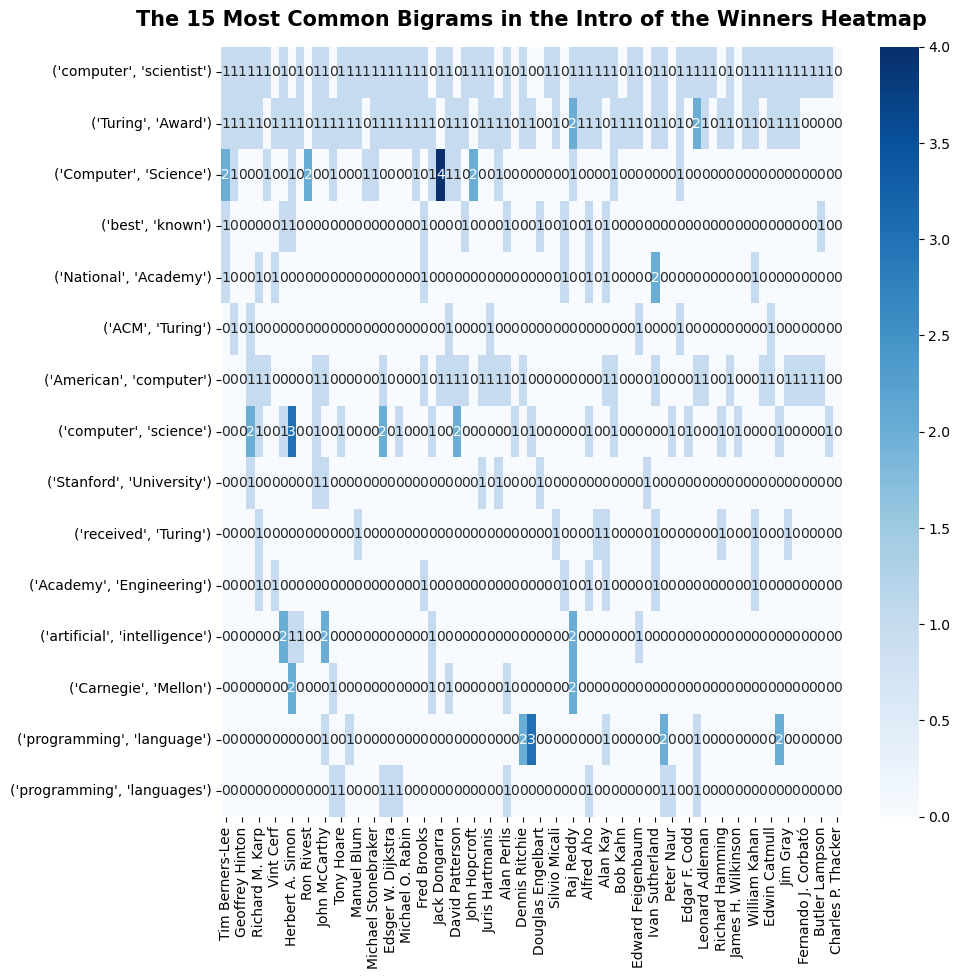

In [505]:
plt.figure(figsize = (10,10))
plt.title("The 15 Most Common Bigrams in the Intro of the Winners Heatmap", fontsize=15, pad=15, fontweight="bold")
sns.heatmap(heatmap_df_transpose, cmap = "Blues", annot = True)